<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/lesson7/ML_business_hw_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")

# 1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [2]:
! mkdir ~/.kaggle
from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets download fedesoriano/heart-failure-prediction
! unzip -q '/content/heart-failure-prediction.zip'

Saving kaggle.json to kaggle.json
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 5.09MB/s]


In [3]:
df = pd.read_csv('/content/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Заменим некоторые категориальные значения на числовые признаки, для более удобного считывания информации с графиков.

In [4]:
mapping_exercise = {'Y': 1, 'N': 0}
df['ExerciseAngina'] = df['ExerciseAngina'].map(mapping_exercise)

mapping_ST_Slope = {'Up': 1, 'Flat': 0, 'Down': -1}
df['ST_Slope'] = df['ST_Slope'].map(mapping_ST_Slope)

In [5]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,1,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,0,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,1,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,0,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,0,1.2,0,1
914,68,M,ASY,144,193,1,Normal,141,0,3.4,0,1
915,57,M,ASY,130,131,0,Normal,115,1,1.2,0,1
916,57,F,ATA,130,236,0,LVH,174,0,0.0,0,1


# 2. Сделать обзорный анализ выбранного датасета

Attribute Information
* Age: возраст пациента [years]
* Sex: пол пациента [M: Male, F: Female]
* ChestPainType: тип боли в груди [TA: Типичная стенокардия, ATA: Атипичная стенокардия, NAP: Неангинальная боль, ASY: Бессимптомная] 
* RestingBP: кровяное давление в состоянии покоя [mm Hg]
* Cholesterol: сывороточный холестерин [mm/dl]
* FastingBS: уровень сахара в крови натощак [1: если уровень сахара в крови натощак > 120 мг/дл, 0: в противном случае]
* RestingECG: результаты электрокардиограммы в состоянии покоя [Normal: В норме, ST: аномалия зубца ST-T (инверсии зубца T и/или подъем или депрессия ST > 0,05 мВ), ГЛЖ: вероятная или определенная гипертрофия левого желудочка по критериям Эстеса]
* MaxHR: достигнутая максимальная частота сердечных сокращений [числовое значение от 60 до 202]
* ExerciseAngina: Стенокардия, вызванная физической нагрузкой [Y: Да, N: Нет]
* Oldpeak: предыдущий пик = ST (вероятно депрессия ST сегмента, вызванная физической нагрузкой, по сравнению с состоянием покоя) [Числовое значение в состоянии депрессии]
* ST_Slope: наклон сегмента ST пикового упражнения [Вверх: восходящий, Плоский: плоский, Вниз: нисходящий]
* HeartDisease: Сердечная недостаточность: выходной класс [1: болезнь сердца, 0: норма]

In [6]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
ExerciseAngina,918.0,0.404139,0.490992,0.0,0.00,0.0,1.0,1.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
ST_Slope,918.0,0.361656,0.607056,-1.0,0.00,0.0,1.0,1.0
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

[]

<Figure size 288x288 with 0 Axes>

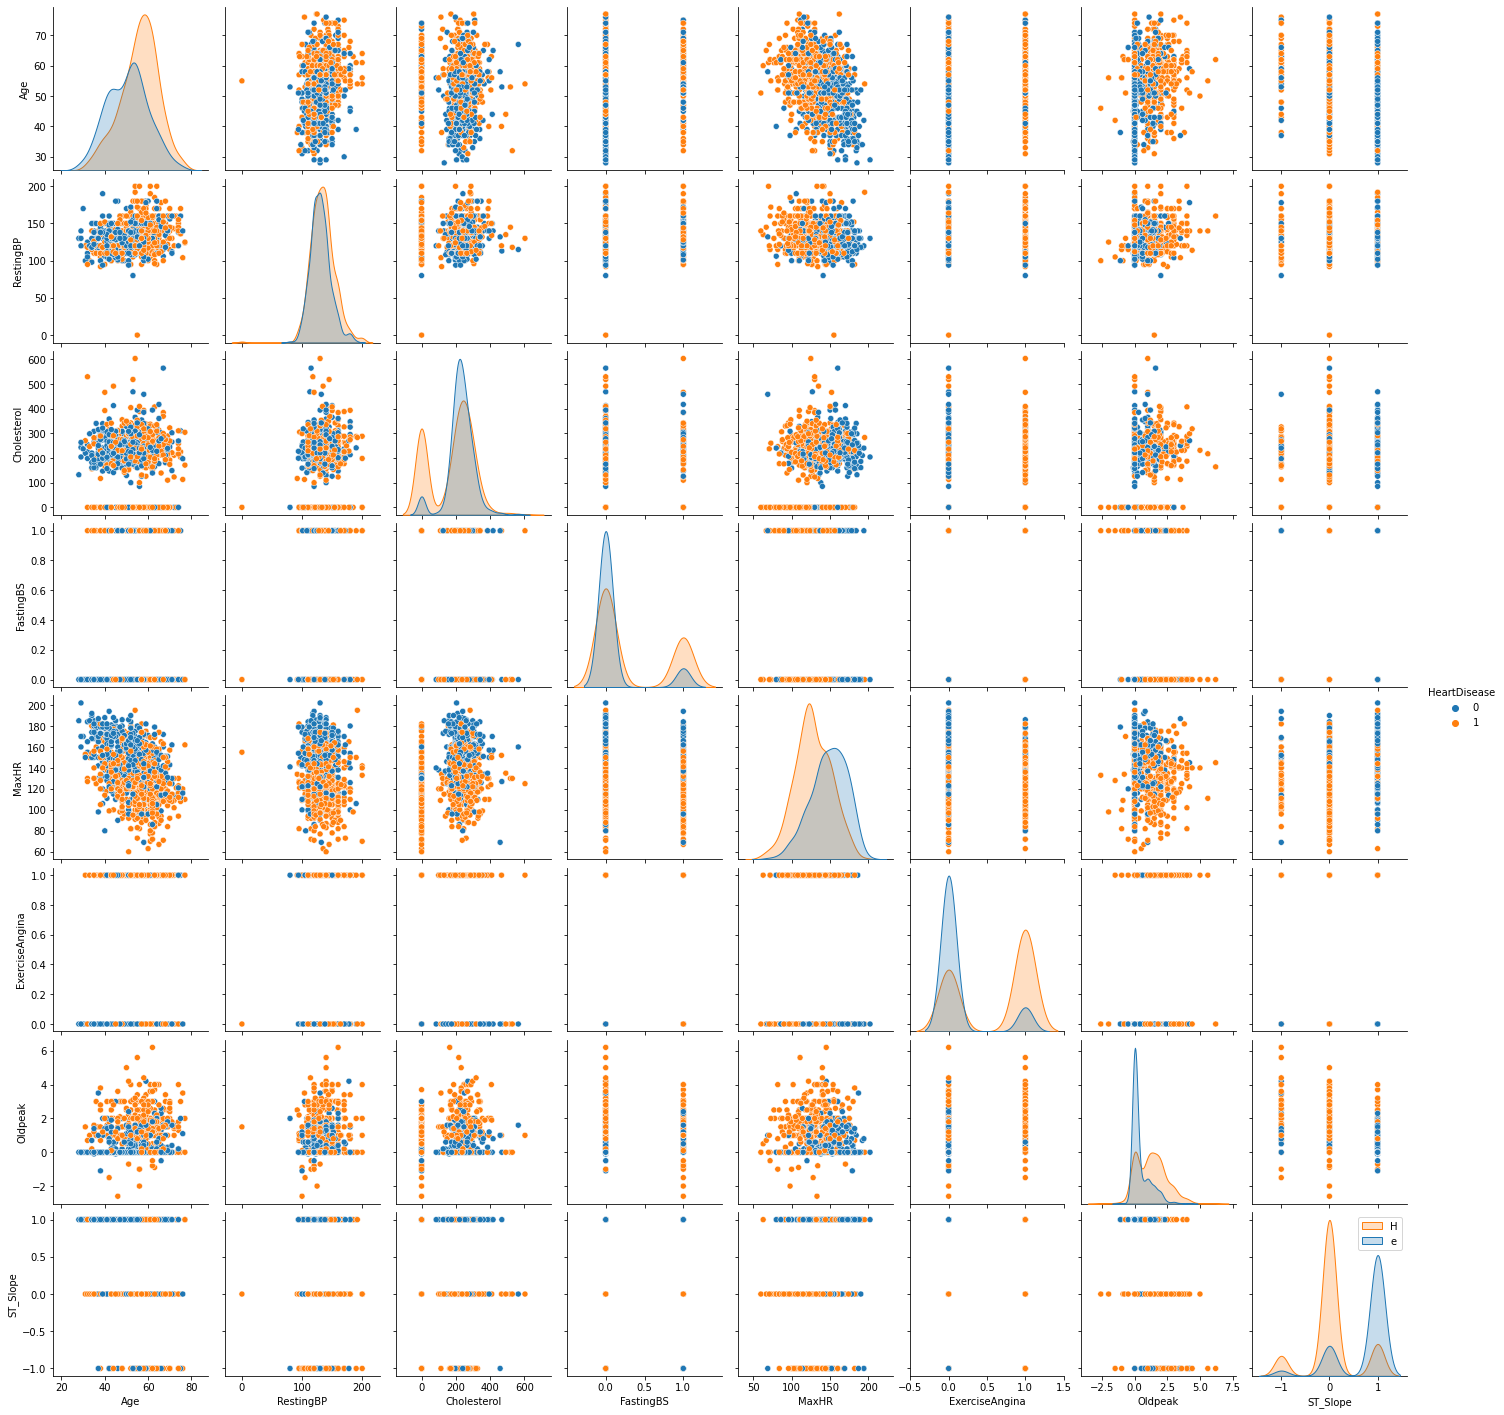

In [35]:
plt.figure(figsize=(4, 4))
sns.pairplot(df, hue="HeartDisease")
plt.legend("HeartDisease")
# plt.tight_layout()
plt.plot()

# 3. Обучить любой классификатор (какой вам нравится)

In [9]:
rs = 7575     

In [12]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['HeartDisease']), df['HeartDisease'], random_state=rs)

In [14]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG']
continuous_columns = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR','Oldpeak', 'ExerciseAngina', 'ST_Slope']

X_train = X_train[categorical_columns + continuous_columns]
X_test = X_test[categorical_columns + continuous_columns]

In [15]:
!pip install catboost -q
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.2 MB/s eta 0:00:00


In [16]:
ct_model = CatBoostClassifier(random_state=rs, n_estimators=50, cat_features=categorical_columns)

In [17]:
# обучим наш пайплайн
ct_model.fit(X_train, y_train)

Learning rate set to 0.136971
0:	learn: 0.6384554	total: 49.3ms	remaining: 2.42s
1:	learn: 0.5957918	total: 51ms	remaining: 1.22s
2:	learn: 0.5633139	total: 52.8ms	remaining: 827ms
3:	learn: 0.5319445	total: 54.4ms	remaining: 625ms
4:	learn: 0.5061825	total: 55.8ms	remaining: 503ms
5:	learn: 0.4822911	total: 57.3ms	remaining: 420ms
6:	learn: 0.4650676	total: 58.7ms	remaining: 361ms
7:	learn: 0.4466741	total: 60.1ms	remaining: 316ms
8:	learn: 0.4315892	total: 61.8ms	remaining: 281ms
9:	learn: 0.4193451	total: 63.3ms	remaining: 253ms
10:	learn: 0.4030341	total: 64.6ms	remaining: 229ms
11:	learn: 0.3913991	total: 66.1ms	remaining: 209ms
12:	learn: 0.3795745	total: 67.5ms	remaining: 192ms
13:	learn: 0.3696065	total: 68.9ms	remaining: 177ms
14:	learn: 0.3591457	total: 70.4ms	remaining: 164ms
15:	learn: 0.3496644	total: 72ms	remaining: 153ms
16:	learn: 0.3422841	total: 73.4ms	remaining: 143ms
17:	learn: 0.3354946	total: 74.9ms	remaining: 133ms
18:	learn: 0.3295963	total: 76.3ms	remaining: 12

In [18]:
# наши прогнозы для тестовой выборки
preds = ct_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.64186694, 0.90631127, 0.89052788, 0.03872651, 0.51148976,
       0.75463186, 0.02561831, 0.07438595, 0.9162824 , 0.92699221])

Найдём лучший threshold.

In [19]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold = {thresholds[ix]}, F-Score = {fscore[ix]:.3f}, Precision = {precision[ix]:.3f}, Recall = {recall[ix]:.3f}')

roc_auc = roc_auc_score(y_test, preds)
print(f'ROC AUC = {roc_auc}')

Best Threshold = 0.5735850586348353, F-Score = 0.884, Precision = 0.880, Recall = 0.887
ROC AUC = 0.931223371880706


# 4.  разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для 5 случайных объектов из тестового набора

In [20]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 30.7 MB/s eta 0:00:00


In [21]:
import shap

explainer = shap.TreeExplainer(ct_model)

In [22]:
preds_train = ct_model.predict_proba(X_train)[:, 1]
# preds_train

In [23]:
%%time
shap_values_all = explainer.shap_values(X_train)

CPU times: user 203 ms, sys: 6.32 ms, total: 209 ms
Wall time: 110 ms


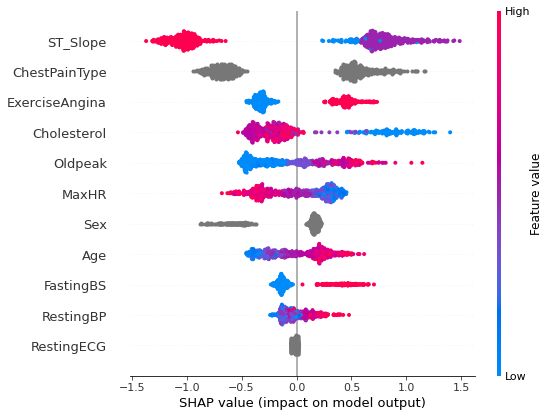

In [24]:
features = categorical_columns + continuous_columns

shap.summary_plot(shap_values_all, X_train, feature_names=features)

Сильнее всего у нас зависимость от наклона ST и типа боли в груди.
* Если наклон на ST сегменте возрастающий, то вероятность болезни меньше. Если же наклон убывающий или плоский, то вероятность болезни больше.
* Тип боли в груди влияет сильно, но при этом мы не заменяли категориальные значения на численные, поэтому не можем интерпретировать значения как более высокие или низкие - отображается на графике серым.
* Если была стенокардия, вызванная нагрузкой, то это риск болезни.
* Высокое содержание холистерола даёт уменьшение риска возникновения болезни.

In [25]:
# visualize the first prediction's explanation
shap.initjs()
idx = 1
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

pred is 0.9383079500304947


Человек скорее всего заболеет из-за высоких значений oldpeak, горизонтального наклона ST-сегмента, типа боли в груди: бессимптомной боли, и из-за наличия стенокардии, вызванной физическими нагрузками.

In [30]:
# visualize the first prediction's explanation
shap.initjs()
idx = np.random.randint(0, 688)
print(f'Объект {idx}')
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

Объект 210
pred is 0.018275242082531305


Человек скорее всего не заболеет. Больше всего сдвигают вероятность риска такие характеристики как возрастающий наклон ST-сегмента, атипичная стенокардия. Высокое значение холистерола, и низкое значение oldpeak. Также сдвигают вероятность болезни в отрицательное значение.

In [31]:
# visualize the first prediction's explanation
shap.initjs()
idx = np.random.randint(0, 688)
print(f'Объект {idx}')
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

Объект 98
pred is 0.041476387471936924


Здесь только относительно низкое значение максимума пика ЧСС влияет на может повлиять на рост вероятности заболевания. Все остальные признаки работают снижают вероятность прогноза заболевания.

In [32]:
# visualize the first prediction's explanation
shap.initjs()
idx = np.random.randint(0, 688)
print(f'Объект {idx}')
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

Объект 303
pred is 0.9410042916322227


Человек имеет высокую вероятность заболевания. Больше всего на такое предсказание влияет горизонтальный наклон ST-сегмента, бессимптомная боль, 

In [33]:
# visualize the first prediction's explanation
shap.initjs()
idx = np.random.randint(0, 688)
print(f'Объект {idx}')
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

Объект 170
pred is 0.9341134737758692


Практически все признаки предполагают возможность болезни. Большой возраст, возникновение стенокардии при нагрузках, ... Наоборот влияют только высокое значение сывороточного холистерола, среднее значение давления, уровень сахара в крови натощак ниже 120.

In [34]:
# visualize the first prediction's explanation
shap.initjs()
idx = np.random.randint(0, 688)
print(f'Объект {idx}')
print('pred is', preds_train[idx])
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], features=X_train.iloc[idx,:], feature_names=features)

Объект 40
pred is 0.023288429299625515


Все характеристики сдвигают вероятность болезни в отрицательную сторону.